# UT Business Process Mining Course project

The goal is to build a regressor that predicts the case duration of loan applications. After training the model, we use the SHAP explainability tool to find the best predictive features and describe the relationships between the features and the predictions.

## Importing libraries

In [1]:
# The code has been written using Python 3.10.4

# Import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport
%matplotlib inline

import BucketFactory
import EncoderFactory
from sklearn.pipeline import FeatureUnion, Pipeline
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


## Read in the event log

In [2]:
# Read in the event log
log = pd.read_csv('data/Dhana Loans 2023.csv',sep=',')

In [3]:
log.head()

,Loan ID,start_time,end_time,ApplicationType,LoanGoal,RequestedAmount,Accepted,Action,CreditScore,EventID,EventOrigin,FirstWithdrawalAmount,MonthlyCost,NumberOfTerms,OfferID,OfferedAmount,Selected,Activity,Resource
0,Application_652823628,2016-01-01T09:51:15.304,2016-01-01T09:51:15.304,New credit,Existing loan takeover,20000.0,,Created,NaN,Application_652823628,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Create Application,User_1
1,Application_652823628,2016-01-01T09:51:15.352,2016-01-01T09:51:15.352,New credit,Existing loan takeover,20000.0,,statechange,NaN,ApplState_1582051990,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Submitted,User_1
2,Application_652823628,2016-01-01T09:52:36.413,2016-01-01T09:52:36.413,New credit,Existing loan takeover,20000.0,,statechange,NaN,ApplState_642383566,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Concept,User_1
3,Application_652823628,2016-01-02T10:45:22.429,2016-01-02T10:45:22.429,New credit,Existing loan takeover,20000.0,,Obtained,NaN,Workitem_1875340971,Workflow,NaN,NaN,NaN,NaN,NaN,NaN,W_Complete application,User_17
4,Application_652823628,2016-01-02T11:23:04.299,2016-01-02T11:23:04.299,New credit,Existing loan takeover,20000.0,,statechange,NaN,ApplState_99568828,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Accepted,User_52


## Change data types, enrich with features

In [4]:
# Convert timestamps to pandas datetime
log['start_time'] = pd.to_datetime(log['start_time'], infer_datetime_format=True)
log['end_time'] = pd.to_datetime(log['end_time'], infer_datetime_format=True)

In [5]:
# A look at data types
log.dtypes

Loan ID                          object
start_time               datetime64[ns]
end_time                 datetime64[ns]
ApplicationType                  object
LoanGoal                         object
RequestedAmount                 float64
Accepted                         object
Action                           object
CreditScore                     float64
EventID                          object
EventOrigin                      object
FirstWithdrawalAmount           float64
MonthlyCost                     float64
NumberOfTerms                   float64
OfferID                          object
OfferedAmount                   float64
Selected                         object
Activity                         object
Resource                         object
dtype: object

In [6]:
# Ratio of NaN values
log.isna().sum()/len(log)

Loan ID                  0.000000
start_time               0.000000
end_time                 0.000000
ApplicationType          0.000000
LoanGoal                 0.000000
RequestedAmount          0.000000
Accepted                 0.000000
Action                   0.000000
CreditScore              0.924904
EventID                  0.000000
EventOrigin              0.000000
FirstWithdrawalAmount    0.924904
MonthlyCost              0.924904
NumberOfTerms            0.924904
OfferID                  0.736003
OfferedAmount            0.924904
Selected                 0.924904
Activity                 0.000000
Resource                 0.000000
dtype: float64

In [9]:
log['num_offers'] = log.groupby('Loan ID')['OfferID'].transform('nunique')

In [10]:
log['num_offers'].value_counts()

1    242202
2     89512
3     16587
4      5703
5      1447
6       297
7       264
8       219
9        61
Name: num_offers, dtype: int64

In [11]:
# Add case start and case end timestamps
log['case_start_timestamp'] = log.groupby('Loan ID').start_time.transform('min')
log['case_end_timestamp'] = log.groupby('Loan ID').end_time.transform('max')

# Add remaining time from case end and time elapsed from case start
log['remtime'] = (log['case_end_timestamp'] - log['end_time']).dt.total_seconds()
log['time_since_case_start'] = (log['start_time'] - log['case_start_timestamp']).dt.total_seconds()

# Add day of the week
log['start_day'] = log['start_time'].dt.dayofweek
log['end_day'] = log['end_time'].dt.dayofweek

# Add the month
log['start_month'] = log['start_time'].dt.month
log['end_month'] = log['end_time'].dt.month

In [12]:
# Function for calculating the relative time (seconds since midnight)
# Source of this function: https://stackoverflow.com/questions/54787146/get-the-time-spent-since-midnight-in-dataframe
def secSinceMidnight(datTimStr):
    tt = pd.to_datetime(datTimStr).time()
    return tt.hour * 3600 + tt.minute * 60 + tt.second

In [13]:
# Add the relative time
log['start_since_midnight'] = log['start_time'].apply(secSinceMidnight)
log['end_since_midnight'] = log['end_time'].apply(secSinceMidnight)

# Add event duration and case duration
log['event_duration'] = (log['end_time'] - log['start_time']).dt.total_seconds()
log['case_duration'] = (log['case_end_timestamp'] - log['case_start_timestamp']).dt.total_seconds()

# Add the differences of event start times and end times
log = log.sort_values(by=['Loan ID', 'start_time'], ascending=True)
log['time_since_last_event_start'] = log.groupby(['Loan ID'])['start_time'].diff().astype('timedelta64[s]').fillna(0)

log = log.sort_values(by=['Loan ID', 'end_time'], ascending=True)
log['time_since_last_event_end'] = log.groupby(['Loan ID'])['end_time'].diff().astype('timedelta64[s]').fillna(0)

In [14]:
# Add waiting time before event

tmp = log.sort_values(by=['Loan ID', 'start_time'], ascending=True)
end_times = tmp.groupby(['Loan ID'])['end_time'].transform(lambda s: s.shift(1))

tmp_2 = pd.concat([tmp[['Loan ID', 'start_time']], end_times], axis=1)
tmp_2['waiting_time_before_event'] = (tmp_2['start_time'] - tmp_2['end_time']).dt.total_seconds().fillna(0)

log.sort_values(by=['Loan ID', 'start_time'], ascending=True)
tmp_2.sort_values(by=['Loan ID', 'start_time'], ascending=True)
log['waiting_time_before_event'] = tmp_2['waiting_time_before_event']

In [15]:
log[['Loan ID', 'start_time', 'end_time', 'waiting_time_before_event']] # Check that the waiting time is correct

,Loan ID,start_time,end_time,waiting_time_before_event
133682,Application_1000158214,2016-06-02 11:14:26.844,2016-06-02 11:14:26.844,0.000
133683,Application_1000158214,2016-06-02 11:14:26.885,2016-06-02 11:14:26.885,0.041
133684,Application_1000158214,2016-06-02 11:15:36.773,2016-06-02 11:15:36.773,69.888
133686,Application_1000158214,2016-06-06 09:10:07.694,2016-06-06 09:10:07.694,-399.175
133687,Application_1000158214,2016-06-06 09:12:02.402,2016-06-06 09:12:02.402,114.708
...,...,...,...,...
282352,Application_999993812,2016-10-19 11:28:11.487,2016-10-19 11:28:11.487,6.655
282353,Application_999993812,2016-10-19 13:44:29.291,2016-10-19 13:44:29.291,8177.804
282354,Application_999993812,2016-10-19 13:44:29.292,2016-10-19 13:44:29.292,0.001
282355,Application_999993812,2016-10-24 07:24:30.056,2016-10-24 07:24:30.056,409200.764


In [16]:
# Check what are unique values for the application final states
log[log.EventOrigin == "Application"].sort_values('start_time', ascending=True, kind='mergesort').groupby("Loan ID").last()["Activity"].unique()

array(['A_Pending', 'A_Cancelled', 'A_Denied'], dtype=object)

In [17]:
# Add the final state as outcome
last_application_state = log[log.EventOrigin == "Application"].sort_values('start_time', ascending=True, kind='mergesort').groupby("Loan ID").last()["Activity"]
last_application_state = pd.DataFrame(last_application_state)
last_application_state.columns = ["outcome"]

di = {'A_Pending': "Pending", 'A_Cancelled': "Cancelled", 'A_Denied':'Denied'}
last_application_state.replace({"outcome": di})

,outcome
Loan ID,
Application_1000158214,Pending
Application_1000311556,Cancelled
Application_1000339879,Pending
Application_100034150,Pending
Application_1000386745,Pending
...,...
Application_998917442,Cancelled
Application_999090530,Pending
Application_999487618,Pending


In [18]:
log = log.merge(last_application_state, left_on="Loan ID", right_index=True)

In [19]:
log.columns

Index(['Loan ID', 'start_time', 'end_time', 'ApplicationType', 'LoanGoal',
       'RequestedAmount', 'Accepted', 'Action', 'CreditScore', 'EventID',
       'EventOrigin', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms',
       'OfferID', 'OfferedAmount', 'Selected', 'Activity', 'Resource',
       'num_offers', 'case_start_timestamp', 'case_end_timestamp', 'remtime',
       'time_since_case_start', 'start_day', 'end_day', 'start_month',
       'end_month', 'start_since_midnight', 'end_since_midnight',
       'event_duration', 'case_duration', 'time_since_last_event_start',
       'time_since_last_event_end', 'waiting_time_before_event', 'outcome'],
      dtype='object')

In [20]:
# features
case_id_col = "Loan ID"
timestamp_col =  'case_end_timestamp'
label_col = 'case_duration'
dynamic_cat_cols = ["Activity", "Resource",
                   "start_day", "end_day", "start_month", "end_month"]
static_cat_cols = ['ApplicationType', 'LoanGoal', 'outcome', 'num_offers']
dynamic_num_cols = ['FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'CreditScore', 'time_since_last_event_end',
                    'time_since_last_event_start', 'waiting_time_before_event', 'event_duration',
                    'start_since_midnight', 'end_since_midnight']
static_num_cols = ['RequestedAmount']

static_cols = static_cat_cols + static_num_cols + [case_id_col, timestamp_col]
dynamic_cols = dynamic_cat_cols + dynamic_num_cols + [timestamp_col]
cat_cols = dynamic_cat_cols + static_cat_cols

In [21]:
log

,Loan ID,start_time,end_time,ApplicationType,LoanGoal,RequestedAmount,Accepted,Action,CreditScore,EventID,...,start_month,end_month,start_since_midnight,end_since_midnight,event_duration,case_duration,time_since_last_event_start,time_since_last_event_end,waiting_time_before_event,outcome
133682,Application_1000158214,2016-06-02 11:14:26.844,2016-06-02 11:14:26.844,New credit,Home improvement,12500.0,,Created,NaN,Application_1000158214,...,6,6,40466,40466,0.0,694054.434,0.0,0.0,0.000,A_Pending
133683,Application_1000158214,2016-06-02 11:14:26.885,2016-06-02 11:14:26.885,New credit,Home improvement,12500.0,,statechange,NaN,ApplState_277536765,...,6,6,40466,40466,0.0,694054.434,0.0,0.0,0.041,A_Pending
133684,Application_1000158214,2016-06-02 11:15:36.773,2016-06-02 11:15:36.773,New credit,Home improvement,12500.0,,statechange,NaN,ApplState_1547990892,...,6,6,40536,40536,0.0,694054.434,69.0,69.0,69.888,A_Pending
133686,Application_1000158214,2016-06-06 09:10:07.694,2016-06-06 09:10:07.694,New credit,Home improvement,12500.0,,statechange,NaN,ApplState_226397461,...,6,6,33007,33007,0.0,694054.434,471.0,338070.0,-399.175,A_Pending
133687,Application_1000158214,2016-06-06 09:12:02.402,2016-06-06 09:12:02.402,New credit,Home improvement,12500.0,true,Created,929.0,Offer_927137349,...,6,6,33122,33122,0.0,694054.434,114.0,114.0,114.708,A_Pending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282352,Application_999993812,2016-10-19 11:28:11.487,2016-10-19 11:28:11.487,New credit,Caravan / Camper,30000.0,,statechange,NaN,OfferState_1258740957,...,10,10,41291,41291,0.0,1528045.960,6.0,6.0,6.655,A_Pending
282353,Application_999993812,2016-10-19 13:44:29.291,2016-10-19 13:44:29.291,New credit,Caravan / Camper,30000.0,,Obtained,NaN,Workitem_1598850294,...,10,10,49469,49469,0.0,1528045.960,8177.0,8177.0,8177.804,A_Pending
282354,Application_999993812,2016-10-19 13:44:29.292,2016-10-19 13:44:29.292,New credit,Caravan / Camper,30000.0,,statechange,NaN,ApplState_756087123,...,10,10,49469,49469,0.0,1528045.960,0.0,0.0,0.001,A_Pending
282355,Application_999993812,2016-10-24 07:24:30.056,2016-10-24 07:24:30.056,New credit,Caravan / Camper,30000.0,,statechange,NaN,OfferState_1927291643,...,10,10,26670,26670,0.0,1528045.960,409200.0,409200.0,409200.764,A_Pending


In [22]:
# Create the log schema
log_schema = {'case_id_col': case_id_col,
              'timestamp_col': timestamp_col,
              'activity_col': 'Activity',
              'label': 'case_duration',
              'static_cat_cols': static_cat_cols,
              'static_num_cols': static_num_cols,
              'dynamic_cat_cols': dynamic_cat_cols,
              'dynamic_num_cols': dynamic_num_cols, 
             }

In [23]:
log = log.replace(r'^\s*$', np.nan, regex=True)

In [24]:
# impute missing values
log_final = log.copy()
grouped = log_final.sort_values(timestamp_col, ascending=True, kind='mergesort').groupby(case_id_col)
for col in static_cols + dynamic_cols:
    log_final[col] = grouped[col].transform(lambda grp: grp.fillna(method='ffill')) # First ffill, then bfill
    log_final[col] = grouped[col].transform(lambda grp: grp.fillna(method='bfill'))

log_final[cat_cols] = log_final[cat_cols].fillna('missing')
log_final = log_final.fillna(0)

In [25]:
log_final.to_csv('./data/processed_log.csv', index=False)

In [26]:
log_final # We only imputed the missing values for the features we are using in the model

,Loan ID,start_time,end_time,ApplicationType,LoanGoal,RequestedAmount,Accepted,Action,CreditScore,EventID,...,start_month,end_month,start_since_midnight,end_since_midnight,event_duration,case_duration,time_since_last_event_start,time_since_last_event_end,waiting_time_before_event,outcome
133682,Application_1000158214,2016-06-02 11:14:26.844,2016-06-02 11:14:26.844,New credit,Home improvement,12500.0,0,Created,929.0,Application_1000158214,...,6,6,40466,40466,0.0,694054.434,0.0,0.0,0.000,A_Pending
133683,Application_1000158214,2016-06-02 11:14:26.885,2016-06-02 11:14:26.885,New credit,Home improvement,12500.0,0,statechange,929.0,ApplState_277536765,...,6,6,40466,40466,0.0,694054.434,0.0,0.0,0.041,A_Pending
133684,Application_1000158214,2016-06-02 11:15:36.773,2016-06-02 11:15:36.773,New credit,Home improvement,12500.0,0,statechange,929.0,ApplState_1547990892,...,6,6,40536,40536,0.0,694054.434,69.0,69.0,69.888,A_Pending
133686,Application_1000158214,2016-06-06 09:10:07.694,2016-06-06 09:10:07.694,New credit,Home improvement,12500.0,0,statechange,929.0,ApplState_226397461,...,6,6,33007,33007,0.0,694054.434,471.0,338070.0,-399.175,A_Pending
133687,Application_1000158214,2016-06-06 09:12:02.402,2016-06-06 09:12:02.402,New credit,Home improvement,12500.0,true,Created,929.0,Offer_927137349,...,6,6,33122,33122,0.0,694054.434,114.0,114.0,114.708,A_Pending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282352,Application_999993812,2016-10-19 11:28:11.487,2016-10-19 11:28:11.487,New credit,Caravan / Camper,30000.0,0,statechange,0.0,OfferState_1258740957,...,10,10,41291,41291,0.0,1528045.960,6.0,6.0,6.655,A_Pending
282353,Application_999993812,2016-10-19 13:44:29.291,2016-10-19 13:44:29.291,New credit,Caravan / Camper,30000.0,0,Obtained,0.0,Workitem_1598850294,...,10,10,49469,49469,0.0,1528045.960,8177.0,8177.0,8177.804,A_Pending
282354,Application_999993812,2016-10-19 13:44:29.292,2016-10-19 13:44:29.292,New credit,Caravan / Camper,30000.0,0,statechange,0.0,ApplState_756087123,...,10,10,49469,49469,0.0,1528045.960,0.0,0.0,0.001,A_Pending
282355,Application_999993812,2016-10-24 07:24:30.056,2016-10-24 07:24:30.056,New credit,Caravan / Camper,30000.0,0,statechange,0.0,OfferState_1927291643,...,10,10,26670,26670,0.0,1528045.960,409200.0,409200.0,409200.764,A_Pending


In [27]:
log_final.isna().sum()

Loan ID                        0
start_time                     0
end_time                       0
ApplicationType                0
LoanGoal                       0
RequestedAmount                0
Accepted                       0
Action                         0
CreditScore                    0
EventID                        0
EventOrigin                    0
FirstWithdrawalAmount          0
MonthlyCost                    0
NumberOfTerms                  0
OfferID                        0
OfferedAmount                  0
Selected                       0
Activity                       0
Resource                       0
num_offers                     0
case_start_timestamp           0
case_end_timestamp             0
remtime                        0
time_since_case_start          0
start_day                      0
end_day                        0
start_month                    0
end_month                      0
start_since_midnight           0
end_since_midnight             0
event_dura

## Train-Test split

In [28]:
# This function is from practice materials
# Split into training and test

def temporal_split(data, log_schema, train_ratio):  
    # Split into train and test using temporal split and discard events that overlap the periods
    data = data.sort_values([log_schema.get('timestamp_col'), log_schema.get('activity_col')], ascending=True, kind='mergesort')
    grouped = data.groupby(log_schema.get('case_id_col'))
    start_timestamps = grouped[log_schema.get('timestamp_col')].min().reset_index()
    start_timestamps = start_timestamps.sort_values(log_schema.get('timestamp_col'), ascending=True, kind='mergesort')
    train_ids = list(start_timestamps[log_schema.get('case_id_col')])[:int(train_ratio*len(start_timestamps))]
    train = data[data[log_schema.get('case_id_col')].isin(train_ids)].sort_values([log_schema.get('timestamp_col'), log_schema.get('activity_col')], ascending=True, kind='mergesort')
    test = data[~data[log_schema.get('case_id_col')].isin(train_ids)].sort_values([log_schema.get('timestamp_col'), log_schema.get('activity_col')], ascending=True, kind='mergesort')
    split_ts = test[log_schema.get('timestamp_col')].min()
    train = train[train[log_schema.get('timestamp_col')] < split_ts]
    return (train, test)

In [29]:
# Do the temporal split into train and test set
train, test = temporal_split(log_final, log_schema, 0.8)
len(train), len(test)

(284671, 71621)

## Prefix data

In [30]:
# Determine min and max (truncated) prefix lengths
# Function is from practice materials
min_prefix_length = 1
def get_pos_case_length_quantile(data, log_schema, quantile=0.90):
    return int(np.ceil(data.groupby(log_schema.get('case_id_col')).size().quantile(quantile)))
max_prefix_length = min(40, get_pos_case_length_quantile(log, log_schema, 0.90))

In [31]:
# Function is from practice materials
def generate_prefix_data(data, min_length, max_length, log_schema, gap=1):
    # generate prefix data (each possible prefix becomes a trace)
    data['case_length'] = data.groupby(log_schema.get('case_id_col'))[log_schema.get('activity_col')].transform(len)

    dt_prefixes = data[data['case_length'] >= min_length].groupby(log_schema.get('case_id_col')).head(min_length)
    dt_prefixes["prefix_nr"] = 1
    dt_prefixes["orig_case_id"] = dt_prefixes[log_schema.get('case_id_col')]
    for nr_events in range(min_length+gap, max_length+1, gap):
        tmp = data[data['case_length'] >= nr_events].groupby(log_schema.get('case_id_col')).head(nr_events)
        tmp["orig_case_id"] = tmp[log_schema.get('case_id_col')]
        tmp[log_schema.get('case_id_col')] = tmp[log_schema.get('case_id_col')].apply(lambda x: "%s_%s"%(x, nr_events))
        tmp["prefix_nr"] = nr_events
        dt_prefixes = pd.concat([dt_prefixes, tmp], axis=0)

    dt_prefixes['case_length'] = dt_prefixes['case_length'].apply(lambda x: min(max_length, x))

    return dt_prefixes

In [32]:
dt_train_prefixes = generate_prefix_data(train, min_prefix_length, max_prefix_length, log_schema)
dt_test_prefixes = generate_prefix_data(test, min_prefix_length, max_prefix_length, log_schema)

In [33]:
len(dt_train_prefixes)

2658148

In [34]:
print(dt_train_prefixes.prefix_nr.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


## Single Bucketing

For simplicity, we only use single bucketing here.

In [35]:
random_state = 22
bucketer_args = {'case_id_col': log_schema.get('case_id_col'), 
                 'cat_cols':[log_schema.get('activity_col')], 
                 'num_cols':[], 
                 'random_state':random_state}

In [36]:
bucket_method = 'single'
bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)
bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
bucket_assignments_test = bucketer.predict(dt_test_prefixes)

In [37]:
print('Train assignments:')
bucket_assignments_train
print(pd.DataFrame(bucket_assignments_train, columns=['bucket']).bucket.value_counts())
print('Test assignments:')
bucket_assignments_test
print(pd.DataFrame(bucket_assignments_test, columns=['bucket']).bucket.value_counts())

Train assignments:
1    277959
Name: bucket, dtype: int64
Test assignments:
1    69730
Name: bucket, dtype: int64


In [38]:
bucketer.n_states

1

In [39]:
bucket_indexes = dt_train_prefixes.groupby(log_schema.get('case_id_col')).first().index
bucket_indexes = bucket_indexes[bucket_assignments_train == 1]
print(bucket_indexes)

Index(['Application_1000158214', 'Application_1000158214_10',
       'Application_1000158214_11', 'Application_1000158214_12',
       'Application_1000158214_13', 'Application_1000158214_14',
       'Application_1000158214_15', 'Application_1000158214_2',
       'Application_1000158214_3', 'Application_1000158214_4',
       ...
       'Application_999993812_16', 'Application_999993812_17',
       'Application_999993812_2', 'Application_999993812_3',
       'Application_999993812_4', 'Application_999993812_5',
       'Application_999993812_6', 'Application_999993812_7',
       'Application_999993812_8', 'Application_999993812_9'],
      dtype='object', name='Loan ID', length=277959)


In [40]:
def get_label(data):
    y = data.groupby(log_schema.get('case_id_col')).first()[log_schema.get('label')] # one row per case
    return y

In [41]:
bucket_data = dt_train_prefixes[dt_train_prefixes[log_schema.get('case_id_col')].isin(bucket_indexes)]
train_y = get_label(bucket_data)

In [42]:
train_y

Loan ID
Application_1000158214        694054.434
Application_1000158214_10     694054.434
Application_1000158214_11     694054.434
Application_1000158214_12     694054.434
Application_1000158214_13     694054.434
                                ...     
Application_999993812_5      1528045.960
Application_999993812_6      1528045.960
Application_999993812_7      1528045.960
Application_999993812_8      1528045.960
Application_999993812_9      1528045.960
Name: case_duration, Length: 277959, dtype: float64

In [43]:
bucket_indexes = dt_test_prefixes.groupby(log_schema.get('case_id_col')).first().index
bucket_indexes = bucket_indexes[bucket_assignments_test == 1]
print(bucket_indexes)
bucket_data_test = dt_test_prefixes[dt_test_prefixes[log_schema.get('case_id_col')].isin(bucket_indexes)]
test_y = get_label(bucket_data_test)

Index(['Application_1000386745', 'Application_1000386745_10',
       'Application_1000386745_11', 'Application_1000386745_12',
       'Application_1000386745_13', 'Application_1000386745_14',
       'Application_1000386745_15', 'Application_1000386745_16',
       'Application_1000386745_17', 'Application_1000386745_18',
       ...
       'Application_998917442_11', 'Application_998917442_12',
       'Application_998917442_2', 'Application_998917442_3',
       'Application_998917442_4', 'Application_998917442_5',
       'Application_998917442_6', 'Application_998917442_7',
       'Application_998917442_8', 'Application_998917442_9'],
      dtype='object', name='Loan ID', length=69730)


In [44]:
test_y

Loan ID
Application_1000386745        948447.917
Application_1000386745_10     948447.917
Application_1000386745_11     948447.917
Application_1000386745_12     948447.917
Application_1000386745_13     948447.917
                                ...     
Application_998917442_5      2718583.161
Application_998917442_6      2718583.161
Application_998917442_7      2718583.161
Application_998917442_8      2718583.161
Application_998917442_9      2718583.161
Name: case_duration, Length: 69730, dtype: float64

## Pipeline: create encodings and train XGBoost Regressor to predict case duration

In [45]:
methods = ['agg'] # Aggregation encoding
feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **log_schema)) for method in methods])
feature_combiner

FeatureUnion(transformer_list=[('agg',
                                <transformers.AggregateTransformer.AggregateTransformer object at 0x000001EB5A8C4520>)])

In [46]:
model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.3, n_jobs=2, random_state=0) # Ideally, CV and hyperparam optimization should be added

In [47]:
pipeline = Pipeline([('encoder', feature_combiner), ('xgb', model)])
pipeline.fit(bucket_data, train_y)

Pipeline(steps=[('encoder',
                 FeatureUnion(transformer_list=[('agg',
                                                 <transformers.AggregateTransformer.AggregateTransformer object at 0x000001EB5A8C4520>)])),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feat...None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.3,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=400, n_jobs=2, num_parallel_tree=1,
                              predictor='auto', random_state=0, ...))])

In [48]:
preds = pipeline.predict(bucket_data_test)
print(preds)

[ 996112.06 1377121.8  1365011.4  ... 2818440.   2806778.   2809033.  ]


In [132]:
mean_absolute_error(test_y, preds)

432589.0180553372

## Plot feature importances

In [50]:
feature_names = pipeline.named_steps["encoder"].get_feature_names()
feature_names

c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['agg__start_day',
 'agg__end_day',
 'agg__start_month',
 'agg__end_month',
 'agg__Activity_A_Accepted',
 'agg__Activity_A_Cancelled',
 'agg__Activity_A_Complete',
 'agg__Activity_A_Concept',
 'agg__Activity_A_Create Application',
 'agg__Activity_A_Denied',
 'agg__Activity_A_Incomplete',
 'agg__Activity_A_Pending',
 'agg__Activity_A_Submitted',
 'agg__Activity_A_Validating',
 'agg__Activity_O_Accepted',
 'agg__Activity_O_Cancelled',
 'agg__Activity_O_Create Offer',
 'agg__Activity_O_Created',
 'agg__Activity_O_Refused',
 'agg__Activity_O_Returned',
 'agg__Activity_O_Sent (mail and online)',
 'agg__Activity_O_Sent (online only)',
 'agg__Activity_W_Assess potential fraud',
 'agg__Activity_W_Call after offers',
 'agg__Activity_W_Call incomplete files',
 'agg__Activity_W_Complete application',
 'agg__Activity_W_Handle leads',
 'agg__Activity_W_Shortened completion',
 'agg__Activity_W_Validate application',
 'agg__Resource_User_1',
 'agg__Resource_User_10',
 'agg__Resource_User_100',
 'agg_

In [51]:
importances = pipeline.named_steps["xgb"].feature_importances_.flatten()

In [52]:
# Zip coefficients and names together and make a DataFrame
# Source of this code: https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
zipped = zip(feature_names, importances)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

In [65]:
df[:20]

,feature,value,abs_value,colors
190,agg__time_since_last_event_end_sum,0.156237,0.156237,green
186,agg__CreditScore_min,0.055168,0.055168,green
10,agg__Activity_A_Incomplete,0.035926,0.035926,green
171,agg__MonthlyCost_min,0.027529,0.027529,green
5,agg__Activity_A_Cancelled,0.023751,0.023751,green
16,agg__Activity_O_Create Offer,0.023035,0.023035,green
188,agg__time_since_last_event_end_max,0.021442,0.021442,green
13,agg__Activity_A_Validating,0.016716,0.016716,green
28,agg__Activity_W_Validate application,0.015802,0.015802,green
6,agg__Activity_A_Complete,0.013961,0.013961,green


C:\Users\kohvk\AppData\Local\Temp\ipykernel_20852\3057028895.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0, 0.5, 'Feature Name')

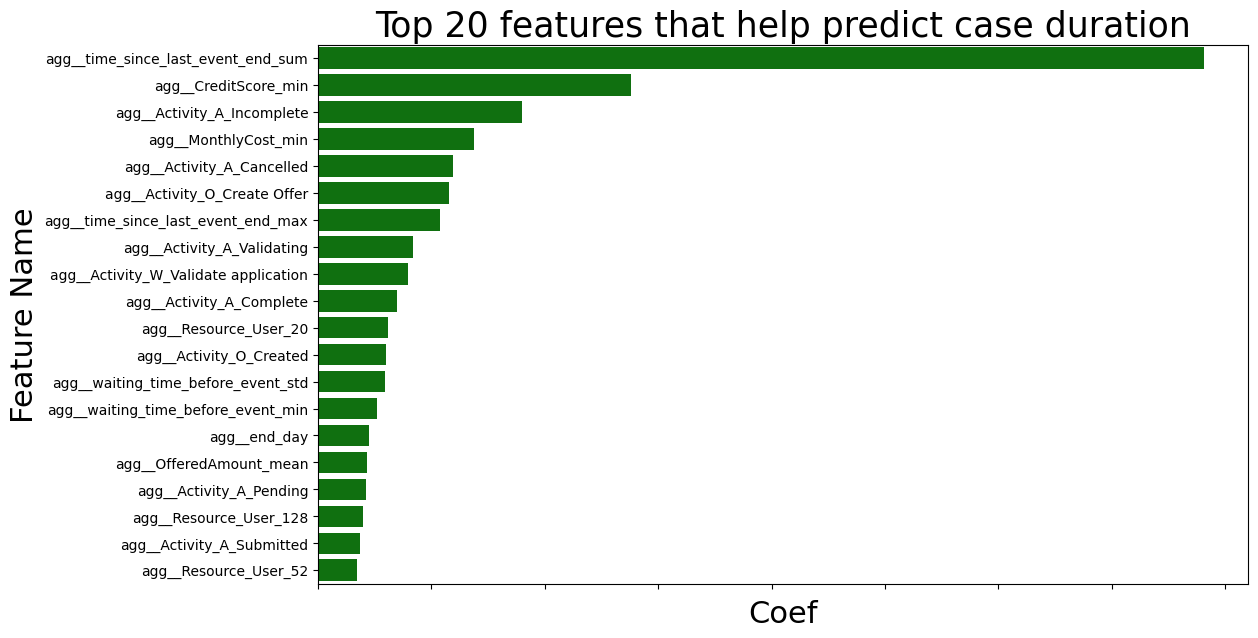

In [54]:
# Plot feature importances
# Source of this code: https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(y="feature",
            x="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 features that help predict case duration", fontsize=25)
ax.set_xlabel("Coef", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22)

## SHAP

In [55]:
import shap

c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(

In [56]:
encodings = feature_combiner.fit_transform(bucket_data, train_y)

In [126]:
encodings.shape

(277959, 218)

In [57]:
explainer = shap.TreeExplainer(pipeline.named_steps["xgb"])
shap_values = explainer.shap_values(encodings)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap_obj = explainer(encodings)
exp = shap.Explanation(shap_obj.values, 
                  shap_obj.base_values, 
                  data=encodings, 
                  feature_names=feature_names)

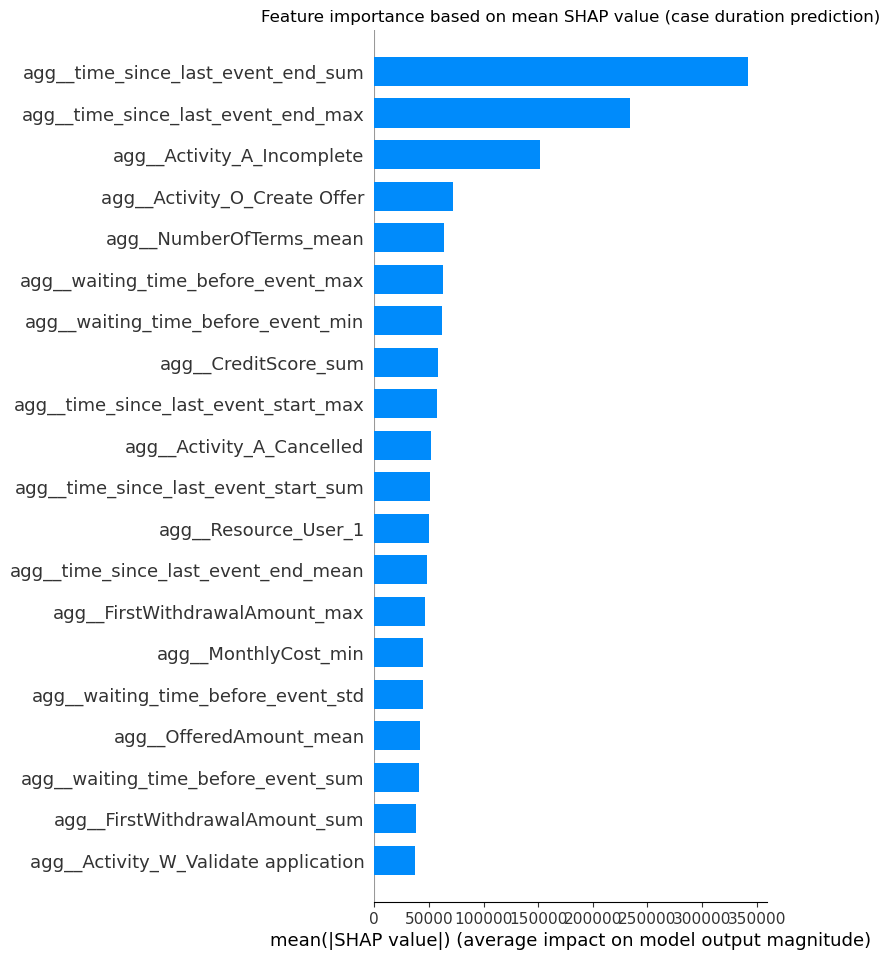

In [120]:
shap.summary_plot(shap_values=shap_values, features=encodings, feature_names=feature_names,plot_type="bar", show=False)
ax = plt.gca()
ax.set_title('Feature importance based on mean SHAP value (case duration prediction)')
plt.show()

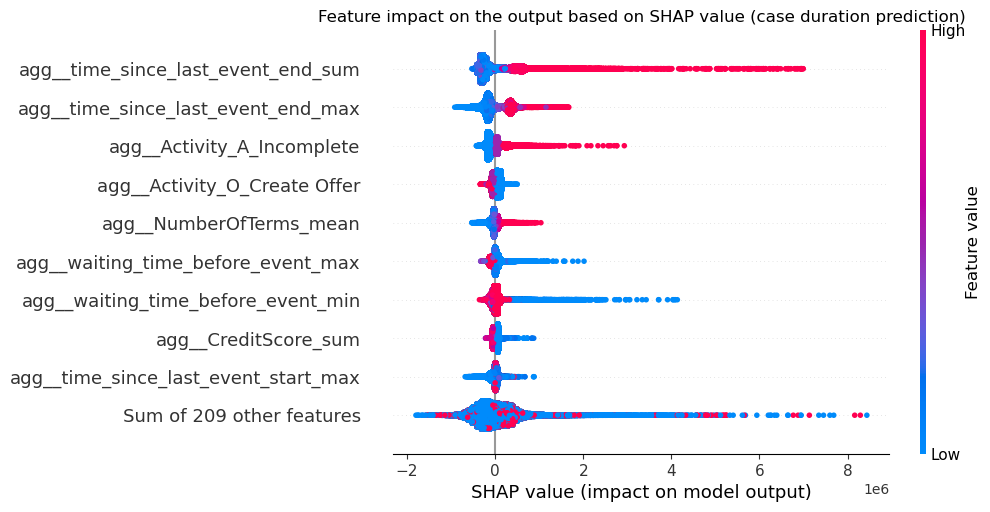

In [121]:
shap.plots.beeswarm(exp, show=False)
ax = plt.gca()
ax.set_title('Feature impact on the output based on SHAP value (case duration prediction)')
plt.show()

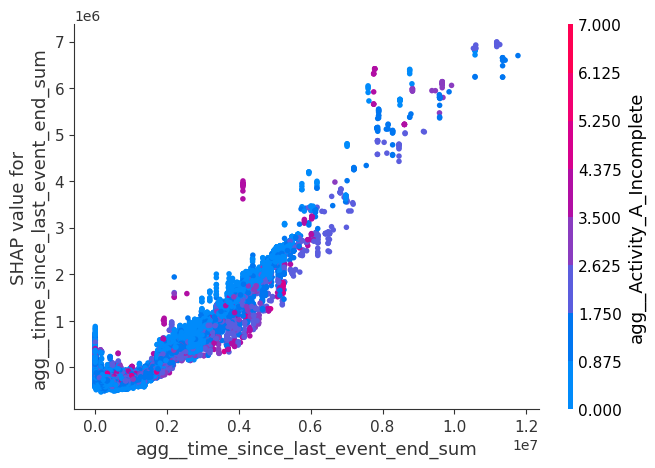

In [124]:
shap.dependence_plot("rank(0)", shap_values=shap_values, features=encodings, feature_names=feature_names)

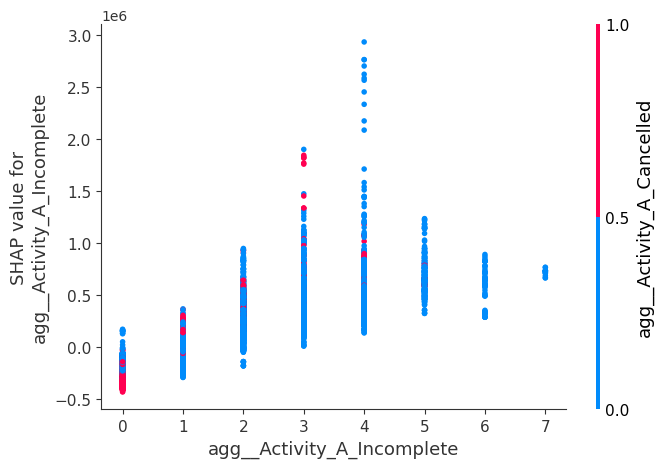

In [80]:
shap.dependence_plot("rank(2)", shap_values=shap_values, features=encodings, feature_names=feature_names)

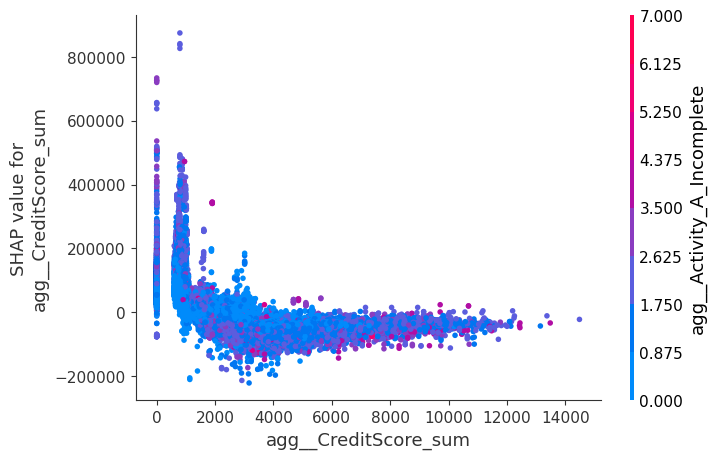

In [130]:
shap.dependence_plot("rank(7)", shap_values=shap_values, features=encodings, feature_names=feature_names)

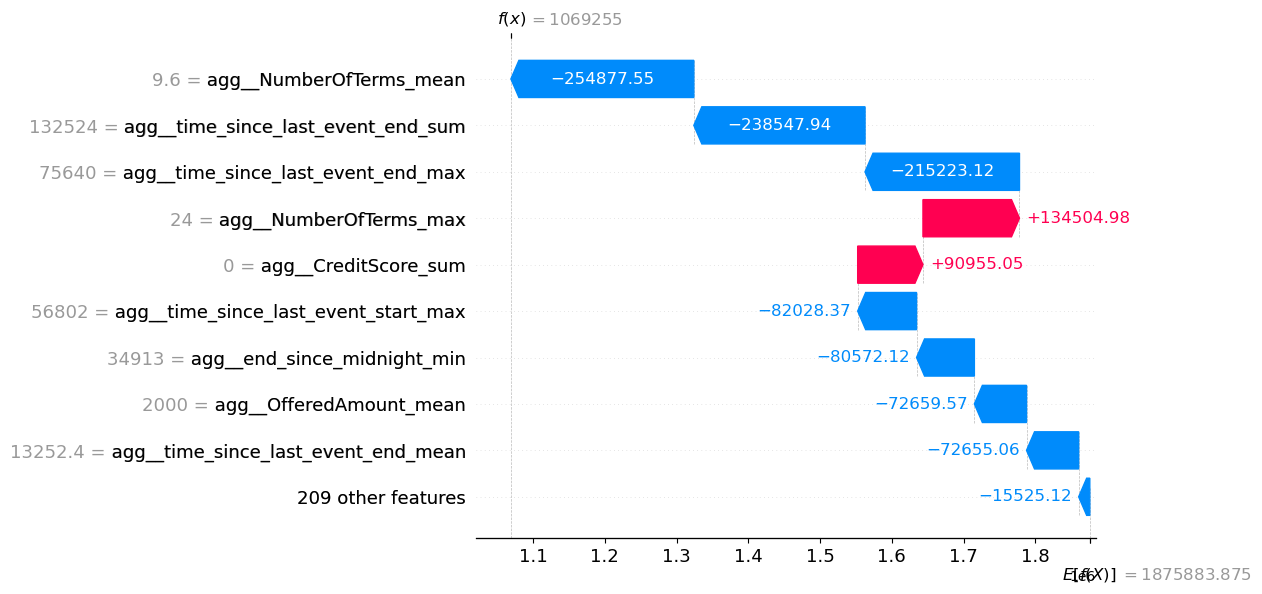

In [131]:
shap.plots.waterfall(exp[100])